<a href="https://colab.research.google.com/github/pras1978/AAI-510/blob/main/MultiAgent%20System%20V1.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Agentic AI Investment Research System - AAPL Stock

---

## Agent Design and Workflows

This project builds a **mini multi-agent financial research system** for the stock **AAPL (Apple Inc.)**.  
Each agent specializes in one information source - news, prices, or filings - and all are coordinated through a structured workflow that mimics a real-world research stack.

### Overall Workflow
1. **Collect** data  
   - Download recent AAPL price history (Yahoo Finance).  
   - Fetch or mock financial news headlines.  
   - Provide a short earnings filing text snippet.  

2. **Prepare / Preprocess**  
   - Clean and normalize news text.  
   - Compute a simple lexicon-based sentiment score per headline.  
   - Convert `published_time` to datetime and group daily averages.  

3. **Planner and Routing**  
   - The Planner creates the ordered step list:  
     `collect -> preprocess -> route -> agents -> aggregate -> evaluate -> optimize -> memory -> output`.  
   - The Router directs each dataset to its correct specialist agent.  

4. **Agents Run**  
   - `NewsSentimentAgent` analyzes headlines and detects themes.  
   - `TrendAgent` studies stock prices to find short-term technical patterns.  
   - `EarningsAgent` scans the filing text for key terms (revenue, EPS, guidance, risks).  

5. **Aggregate**  
   - Merge all agent outputs into one structured research draft.  

6. **Evaluate, Optimize, Memory, and Output**  
   - Evaluate report quality, polish if needed, record memory, and display results with a chart.

This modular design ensures each component can be improved independently (for example, swapping in a transformer model later).

---

## Agent Functions and Capabilities

| Agent | Input | Core Function | Output / Capability |
|:------|:------|:---------------|:--------------------|
| **NewsSentimentAgent** | Cleaned news DataFrame | 1. Computes sentiment per headline<br>2. Groups daily average sentiment<br>3. Tags major themes (iPhone, Services, AI, Regulatory) | `headline_level`, `daily_sentiment`, `themes` |
| **TrendAgent** | Price DataFrame (Date, Close) | 1. Calculates 5-day return, 10-day volatility<br>2. Detects MA-crossover (bullish/bearish) and 20-day breakout | `trend_table`, `trend_summary` |
| **EarningsAgent** | Filing text paragraph | 1. Checks for keywords: revenue, EPS, guidance, risks<br>2. Computes tone (positive / neutral / negative) | `filing_summary` |
| **Aggregator** | All agent outputs | Combines results into a readable research report with Market, News, Filing, and Initial Take sections | `draft_text` |
| **Evaluator and Optimizer** | Draft report | Scores coverage, correctness, coherence, then improves clarity and adds a "Risks & Next Steps" section | `scores`, `final_text` |
| **Memory** | Key metrics | Saves quick notes (overall score, sentiment, trend state) for learning across runs | `memory_notes.json` |

Together, these agents emulate an analyst team: the News agent reads headlines, the Trend agent inspects charts, and the Earnings agent interprets reports.

---

## Evaluation and Iteration

### Evaluation Metrics
1. **Coverage (0-1)** - Did the report include trend, news, and filing data?  
2. **Correctness (0-1)** - Does the latest sentiment agree with the next-day price move?  
3. **Coherence (0-1)** - Is the writing clear and connected (average sentence length heuristic)?  
4. **Overall Score** - Mean of the three metrics.



# Research — AAPL

This brief synthesizes recent price action, headlines, and filing highlights into a concise view.
## Market/Trend Snapshot
- Last Close: $252.29
- 5D Return: 1.87%
- 10D Volatility (stdev of returns): 0.0150
- MA Crossover: Bearish
- 20D Breakout: False

## News Summary
- Note: Despite the news sentiment, the immediate next-day price move diverged, suggesting other drivers dominated.
- Latest Daily Net Sentiment: +0.000
- Notable themes: ai, iphone, services

## Filing Snapshot
- Tone: positive
- Mentions: revenue, eps, guidance, risks

## Initial Take
- Setup looks constructive given services strength and device cycle; monitor regulatory headlines and FX headwinds.
Overall, we balance upside drivers with identifiable risks to frame a practical takeaway.

## Risks & Next Steps
- Monitor regulatory/antitrust items affecting App Store economics.
- Track FX headwinds and China demand trends.
- Validate services margin sustainability next quarter.

Github Link 🇱ink https://github.com/pras1978/AAI-510/blob/f2409a634209137fa843d4ee49839535cbb548b7/MultiAgent%20System%20.ipynb

In [44]:
# --- Imports & config
import json
import math
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

np.random.seed(7)
TICKER = "AAPL"

# Pretty display
pd.set_option("display.width", 120)
pd.set_option("display.max_colwidth", 120)


In [45]:
# --- 1A) Prices (last 6 months, daily)
# Force stable columns from yfinance and flatten if MultiIndex appears
prices_df = yf.download(TICKER, period="6mo", interval="1d", auto_adjust=False).rename_axis("Date").reset_index()

# If yfinance returns a MultiIndex (e.g., ('Close','AAPL')), flatten to single level
if isinstance(prices_df.columns, pd.MultiIndex):
    prices_df.columns = [c[0] if isinstance(c, tuple) else c for c in prices_df.columns]

prices_df = prices_df.reset_index()  # Date becomes a column
assert not prices_df.empty, "No price data returned. Check ticker or internet."

# --- 1B) Headlines (Yahoo Finance feed via yfinance)
news_raw = []
try:
    news_raw = yf.Ticker(TICKER).news or []
except Exception as e:
    print("Warning: Could not fetch headlines via yfinance:", e)

# Normalize minimal fields
rows = []
for n in news_raw:
    rows.append({
        "published_time": n.get("providerPublishTime"),
        "title": n.get("title"),
        "publisher": n.get("publisher"),
        "link": n.get("link"),
    })
news_df = pd.DataFrame(rows)

if not news_df.empty and pd.api.types.is_numeric_dtype(news_df["published_time"]):
    news_df["published_time"] = pd.to_datetime(news_df["published_time"], unit="s", errors="coerce")

# Fallback: add 3 mock headlines if feed is empty
if news_df.empty:
    print("No headlines from API. Using 3 fallback headlines so pipeline can run.")
    fallback_dates = pd.bdate_range(end=pd.Timestamp.today().normalize(), periods=3)
    news_df = pd.DataFrame({
        "published_time": fallback_dates,
        "title": [
            "Apple services revenue hits record; App Store growth accelerates",
            "Analysts cite strong iPhone demand into holiday season",
            "Apple faces regulatory scrutiny over App Store fees in EU"
        ],
        "publisher": ["Fallback"]*3,
        "link": [""]*3
    })

# --- 1C) Filing snippet (tiny, to demonstrate Earnings Agent)
filing_text = (
    "Apple reported quarterly revenue growth and EPS improvement; guidance cautious on FX headwinds; "
    "continued investment in AI features across devices; risks include regulatory scrutiny."
)

print("Prices shape:", prices_df.shape)
print("Headlines count:", len(news_df))
print(prices_df.head(2))



[*********************100%***********************]  1 of 1 completed

Prices shape: (126, 8)
Headlines count: 10
   index       Date   Adj Close       Close        High         Low        Open    Volume
0      0 2025-04-21  192.688339  193.160004  193.800003  189.809998  193.270004  46742500
1      1 2025-04-22  199.252289  199.740005  201.589996  195.970001  196.119995  52976400


In [46]:
# ==== STEP 2 — Prepare & Preprocess with fallback so daily_sent is never empty ====

import pandas as pd

# 2A) Utils
POS_WORDS = {
    "record","accelerates","strong","improve","upbeat","rise","growth",
    "expand","expanded","increase","improves","demand","beats","ai","features"
}
NEG_WORDS = {
    "scrutiny","delay","risk","risks","regulatory","antitrust","headwinds",
    "concern","weak","miss","down","decline"
}

def clean_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    return "".join(ch.lower() if ch.isalnum() or ch.isspace() else " " for ch in text).strip()

def lexicon_sentiment(text: str) -> float:
    toks = clean_text(text).split()
    if not toks:
        return 0.0
    pos = sum(1 for w in toks if w in POS_WORDS)
    neg = sum(1 for w in toks if w in NEG_WORDS)
    return (pos - neg) / max(1, len(toks))

def _make_fallback_news(n: int = 6) -> pd.DataFrame:
    # A small mix of positive/negative/neutral titles across recent business days
    dates = pd.bdate_range(end=pd.Timestamp.today().normalize(), periods=n)
    titles = [
        "Apple services revenue hits record; App Store growth accelerates",
        "Analysts cite strong iPhone demand into holiday season",
        "Apple faces regulatory scrutiny over App Store fees in EU",
        "Report hints at new AI features planned across devices",
        "Supply chain headwinds ease; production outlook improves",
        "Guidance cautious on FX risks despite upbeat quarter",
    ][:n]
    return pd.DataFrame({
        "published_time": dates,
        "title": titles,
        "publisher": ["Fallback"]*len(titles),
        "link": [""]*len(titles),
    })

# 2B) Start from whatever was collected
df = news_df.copy() if 'news_df' in globals() else pd.DataFrame()

# If nothing collected or titles are all empty, inject fallback immediately
if df.empty or ("title" not in df.columns) or df["title"].fillna("").str.strip().eq("").all():
    df = _make_fallback_news()

# Clean titles and deduplicate
df["clean"] = df["title"].map(clean_text)
df = df.drop_duplicates(subset=["clean"]).reset_index(drop=True)

# Sentiment per headline
df["sentiment"] = df["title"].map(lexicon_sentiment)

# Robust datetime handling
df["published_time"] = pd.to_datetime(df.get("published_time"), errors="coerce")
if df["published_time"].isna().all():
    # if all dates are invalid, assign recent business days to keep pipeline alive
    df["published_time"] = pd.bdate_range(end=pd.Timestamp.today().normalize(), periods=len(df))
else:
    df = df.dropna(subset=["published_time"])

# Final order
df = df.sort_values("published_time").reset_index(drop=True)

# Compute daily average sentiment
daily_sent = (
    df.assign(day=df["published_time"].dt.date)
      .groupby("day", as_index=True)["sentiment"].mean()
      .rename("daily_sentiment")
)

# Expose back as news_df for later steps
news_df = df

print("Preprocessed headlines:", len(news_df))
print("Daily sentiment tail:")
print(daily_sent.tail(5))


Preprocessed headlines: 6
Daily sentiment tail:
day
2025-10-14    0.250000
2025-10-15   -0.200000
2025-10-16    0.222222
2025-10-17    0.000000
2025-10-20    0.000000
Name: daily_sentiment, dtype: float64


In [47]:
class PlannerAgent:
    def plan(self, ticker: str) -> dict:
        steps = [
            "collect", "prepare_preprocess", "routing",
            "agents_run", "aggregate", "evaluate", "optimize", "memory", "final_output"
        ]
        return {"ticker": ticker, "steps": steps}

planner = PlannerAgent()
plan = planner.plan(TICKER)
plan


{'ticker': 'AAPL',
 'steps': ['collect',
  'prepare_preprocess',
  'routing',
  'agents_run',
  'aggregate',
  'evaluate',
  'optimize',
  'memory',
  'final_output']}

In [48]:
class Router:
    def route(self, prices: pd.DataFrame, headlines: pd.DataFrame, filing: str) -> dict:
        out = {}
        # Be lenient: we just need a 'Close' column and a few rows
        if isinstance(prices, pd.DataFrame) and "Close" in prices.columns and len(prices) >= 5:
            out["prices_df"] = prices
        if isinstance(headlines, pd.DataFrame) and "clean" in headlines.columns:
            out["news_df"] = headlines
        if isinstance(filing, str) and filing.strip():
            out["filing_text"] = filing.strip()
        return out

router = Router()


In [49]:
routes = router.route(prices_df, news_df, filing_text)
print("routes keys:", list(routes.keys()))   # expect: ['prices_df','news_df','filing_text']


routes keys: ['prices_df', 'news_df', 'filing_text']


In [50]:
# ==== STEP 5 — Agents (News / Trend / Earnings) ====
import numpy as np
import pandas as pd

class NewsSentimentAgent:
    def run(self, news_df: pd.DataFrame) -> dict:
        df = news_df.copy()

        # Ensure published_time is datetime to allow .dt access
        if "published_time" in df.columns and not pd.api.types.is_datetime64_any_dtype(df["published_time"]):
            df["published_time"] = pd.to_datetime(df["published_time"], errors="coerce")

        # Ensure sentiment exists (in case Step 2 didn’t create it)
        if "sentiment" not in df.columns:
            # Fallback tiny lexicon if not in scope
            POS_WORDS = {
                "record","accelerates","strong","improve","upbeat","rise","growth","expand","expanded",
                "increase","improves","demand","beats","ai","features"
            }
            NEG_WORDS = {
                "scrutiny","delay","risk","risks","regulatory","antitrust","headwinds","concern","weak","miss","down","decline"
            }
            def _clean(t):
                t = t if isinstance(t, str) else ""
                return "".join(ch.lower() if ch.isalnum() or ch.isspace() else " " for ch in t).strip()
            def _score(t):
                toks = _clean(t).split()
                if not toks: return 0.0
                pos = sum(1 for w in toks if w in POS_WORDS)
                neg = sum(1 for w in toks if w in NEG_WORDS)
                return (pos - neg) / max(1, len(toks))
            df["sentiment"] = df["title"].map(_score)

        # Tag a few themes
        themes = []
        for _, row in df.iterrows():
            t = (row.get("clean") if isinstance(row.get("clean"), str) else "") or \
                ("".join(ch.lower() if ch.isalnum() or ch.isspace() else " " for ch in str(row.get("title",""))))
            tag = None
            if "iphone" in t: tag = "iphone"
            elif "services" in t or "app store" in t: tag = "services"
            elif "china" in t: tag = "china"
            elif "regulatory" in t or "antitrust" in t: tag = "regulatory"
            elif "ai" in t or "features" in t: tag = "ai"
            if tag:
                d = row.get("published_time")
                themes.append({
                    "date": d.date() if pd.notnull(d) and hasattr(d, "date") else None,
                    "tag": tag,
                    "title": row.get("title","")
                })

        # Daily average sentiment (guard if published_time missing)
        if "published_time" in df.columns and pd.api.types.is_datetime64_any_dtype(df["published_time"]):
            daily = (
                df.assign(day=df["published_time"].dt.date)
                  .groupby("day")["sentiment"].mean()
                  .rename("daily_sentiment")
            )
        else:
            daily = pd.Series(dtype=float, name="daily_sentiment")

        return {"headline_level": df, "daily_sentiment": daily, "themes": themes}


class TrendAgent:
    def run(self, prices_df: pd.DataFrame) -> dict:
        df = prices_df.copy()

        # Ensure there is a Date column (and it's datetime); sort by Date
        if "Date" not in df.columns:
            if isinstance(df.index, pd.DatetimeIndex):
                df = df.reset_index().rename(columns={"index": "Date"})
            else:
                for cand in ["date", "timestamp", "time"]:
                    if cand in df.columns:
                        df = df.rename(columns={cand: "Date"})
                        break
        if "Date" in df.columns:
            df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
            df = df.sort_values("Date")

        # If Yahoo added duplicate columns accidentally, keep first occurrence
        # (This prevents 'single element Series' issues on label lookup.)
        df = df.loc[:, ~df.columns.duplicated(keep="first")]

        # Sanity: we need Close to proceed
        if "Close" not in df.columns or len(df) < 5:
            return {"trend_table": df, "trend_summary": {}}

        # Compute features
        close = df["Close"].astype(float)
        df["ret"] = close.pct_change()
        df["vol10"] = df["ret"].rolling(10).std()
        df["ma5"] = close.rolling(5).mean()
        df["ma20"] = close.rolling(20).mean()
        df["breakout20"] = close > close.rolling(20).max().shift(1)

        # Extract scalars using .iloc[...] to avoid Series ambiguity
        last_close = float(close.iloc[-1])
        five_day_return_pct = float((close.iloc[-1] / close.iloc[-5] - 1) * 100)
        vol10_val = float(df["vol10"].iloc[-1]) if pd.notnull(df["vol10"].iloc[-1]) else None
        ma5_last = df["ma5"].iloc[-1] if pd.notnull(df["ma5"].iloc[-1]) else np.nan
        ma20_last = df["ma20"].iloc[-1] if pd.notnull(df["ma20"].iloc[-1]) else np.nan
        ma_crossover = "bullish" if (ma5_last > ma20_last) else "bearish"
        breakout20_val = bool(df["breakout20"].iloc[-1]) if pd.notnull(df["breakout20"].iloc[-1]) else False

        summary = {
            "last_close": last_close,
            "five_day_return_pct": five_day_return_pct,
            "vol10": vol10_val,
            "ma_crossover": ma_crossover,
            "breakout20": breakout20_val
        }
        return {"trend_table": df, "trend_summary": summary}


class EarningsAgent:
    def run(self, filing_text: str) -> dict:
        text = (filing_text or "").lower()
        mentions = {
            "revenue": "revenue" in text,
            "eps": "eps" in text,
            "guidance": "guidance" in text,
            "risks": ("risk" in text) or ("regulatory" in text)
        }
        tone_score = 0
        if any(k in text for k in ["expand","expanded","growth"]): tone_score += 1
        if mentions["revenue"]: tone_score += 1
        if mentions["eps"]: tone_score += 1
        if mentions["risks"]: tone_score -= 1
        tone = "positive" if tone_score >= 1 else ("negative" if tone_score <= -1 else "neutral")
        return {"filing_summary": {"mentions": mentions, "tone": tone}}


# ---- Run agents on what's in routes ----
news_out  = NewsSentimentAgent().run(routes["news_df"])       if "news_df"    in routes else {}
trend_out = TrendAgent().run(routes["prices_df"])             if "prices_df"  in routes else {}
earn_out  = EarningsAgent().run(routes["filing_text"])        if "filing_text" in routes else {}

# ---- Quick sanity prints ----
print("routes keys:", list(routes.keys()))
print("news_out keys:", list(news_out.keys()))
print("trend_out keys:", list(trend_out.keys()))
print("earn_out keys:", list(earn_out.keys()))

# Optional peek:
display(news_out.get("headline_level", pd.DataFrame()).tail(3))


routes keys: ['prices_df', 'news_df', 'filing_text']
news_out keys: ['headline_level', 'daily_sentiment', 'themes']
trend_out keys: ['trend_table', 'trend_summary']
earn_out keys: ['filing_summary']


,published_time,title,publisher,link,clean,sentiment
3,2025-10-16,Report hints at new AI features planned across devices,Fallback,,report hints at new ai features planned across devices,0.222222
4,2025-10-17,Supply chain headwinds ease; production outlook improves,Fallback,,supply chain headwinds ease production outlook improves,0.000000
5,2025-10-20,Guidance cautious on FX risks despite upbeat quarter,Fallback,,guidance cautious on fx risks despite upbeat quarter,0.000000


In [51]:
def aggregate(ticker: str, news_out: dict, trend_out: dict, earn_out: dict) -> dict:
    lines = [f"# Research Draft — {ticker}", ""]

    # Market/Trend
    ts = trend_out.get("trend_summary", {})
    lines += [
        "## Market/Trend Snapshot",
        f"- Last Close: ${ts.get('last_close', float('nan')):.2f}" if ts else "- Last Close: n/a",
        f"- 5D Return: {ts['five_day_return_pct']:.2f}%" if ts.get("five_day_return_pct") is not None else "- 5D Return: n/a",
        f"- 10D Volatility (stdev of returns): {ts['vol10']:.4f}" if ts.get("vol10") is not None else "- 10D Volatility: n/a",
        f"- MA Crossover: {ts.get('ma_crossover', 'n/a').title() if ts else 'n/a'}",
        f"- 20D Breakout: {ts.get('breakout20', False)}",
        ""
    ]

    # News
    daily_sent = news_out.get("daily_sentiment", pd.Series(dtype=float))
    latest_sent = float(daily_sent.iloc[-1]) if not daily_sent.empty else float("nan")
    themes = sorted({t["tag"] for t in news_out.get("themes", [])}) if news_out else []
    theme_txt = ", ".join(themes) if themes else "none"
    lines += [
        "## News Summary",
        f"- Latest Daily Net Sentiment: {latest_sent:+.3f}" if not math.isnan(latest_sent) else "- Latest Daily Net Sentiment: n/a",
        f"- Notable themes: {theme_txt}",
        ""
    ]

    # Filing
    fs = earn_out.get("filing_summary", {"tone": "n/a", "mentions": {}})
    lines += [
        "## Filing Snapshot",
        f"- Tone: {fs.get('tone', 'n/a')}",
        f"- Mentions: {', '.join([k for k, v in fs.get('mentions', {}).items() if v]) or 'none'}",
        ""
    ]

    # Initial take
    lines += [
        "## Initial Take",
        "- Setup looks constructive given services strength and device cycle; monitor regulatory headlines and FX headwinds."
    ]

    return {
        "draft_text": "\n".join(lines),
        "latest_sentiment": latest_sent,
        "trend_table": trend_out.get("trend_table", pd.DataFrame())
    }

agg = aggregate(TICKER, news_out, trend_out, earn_out)
print(agg["draft_text"])


# Research Draft — AAPL

## Market/Trend Snapshot
- Last Close: $252.29
- 5D Return: 1.87%
- 10D Volatility (stdev of returns): 0.0150
- MA Crossover: Bearish
- 20D Breakout: False

## News Summary
- Latest Daily Net Sentiment: +0.000
- Notable themes: ai, iphone, services

## Filing Snapshot
- Tone: positive
- Mentions: revenue, eps, guidance, risks

## Initial Take
- Setup looks constructive given services strength and device cycle; monitor regulatory headlines and FX headwinds.


In [53]:
class Evaluator:
    def score(self, report_text: str, has_news: bool, has_trend: bool, has_filing: bool,
              news_sent_last: float, prices: pd.DataFrame) -> dict:
        # Coverage
        coverage = (has_news + has_trend + has_filing) / 3.0

        # Correctness: sign(news sentiment last) vs sign(next-day return on the most recent day with data
# Coverage: each must be non-empty dict with expected keys
        has_news   = bool(news_out) and ("daily_sentiment" in news_out)
        has_trend  = bool(trend_out.get("trend_summary"))
        has_filing = bool(earn_out)

        coverage = (int(has_news) + int(has_trend) + int(has_filing)) / 3.0

        # Correctness: compare sign(latest daily sentiment) vs sign(last available next-day return)
        correctness = 0.5
        try:
            dfp = prices_df.sort_values("Date").copy()
            nxt = dfp["Close"].pct_change().shift(-1).dropna()
            ret_next = nxt.iloc[-1] if len(nxt) else float("nan")
            latest_sent = agg.get("latest_sentiment", float("nan"))
            if not math.isnan(latest_sent) and not math.isnan(ret_next):
                correctness = 1.0 if np.sign(latest_sent) == np.sign(ret_next) else 0.0
        except Exception:
            pass




        # Coherence: average line length heuristic
        lines = [ln.strip() for ln in report_text.split("\n") if ln.strip()]
        avg_len = np.mean([len(ln.split()) for ln in lines]) if lines else 0
        coherence = 1.0 if avg_len >= 6 else 0.6

        overall = round(float((coverage + correctness + coherence) / 3.0), 3)
        return {
            "coverage": round(float(coverage), 3),
            "correctness": round(float(correctness), 3),
            "coherence": round(float(coherence), 3),
            "overall": overall
        }

class Optimizer:
    def improve(self, report_text: str, scores: dict, mismatch_note: bool = True) -> str:
        lines = report_text.splitlines()
        improved = lines[:]

        # Add smooth transitions if coherence is low
        if scores["coherence"] < 1.0:
            improved.insert(2, "This brief synthesizes recent price action, headlines, and filing highlights into a concise view.")
            improved.append("Overall, we balance upside drivers with identifiable risks to frame a practical takeaway.")

        # If correctness is 0, explicitly acknowledge sentiment/price mismatch
        if scores["correctness"] == 0.0 and mismatch_note:
            idx = max(i for i, ln in enumerate(improved) if ln.startswith("## News Summary")) + 1
            improved.insert(idx, "- Note: Despite the news sentiment, the immediate next-day price move diverged, suggesting other drivers dominated.")

        # Always append a short Risks & Next Steps to strengthen coverage/readability
        improved += [
            "",
            "## Risks & Next Steps",
            "- Monitor regulatory/antitrust items affecting App Store economics.",
            "- Track FX headwinds and China demand trends.",
            "- Validate services margin sustainability next quarter."
        ]
        return "\n".join(improved)

evaluator = Evaluator()
scores = evaluator.score(
    agg["draft_text"],
    has_news = not news_df.empty,
    has_trend = not prices_df.empty,
    has_filing = bool(filing_text.strip()),
    news_sent_last = agg["latest_sentiment"],
    prices = prices_df
)
print("Evaluator scores:", scores)

optimizer = Optimizer()
final_text = final_text.replace("none ## Filing Snapshot", "none\n\n## Filing Snapshot")
# Optional: ensure every '## ' heading starts on its own line
final_text = final_text.replace("\n## ", "\n\n## ")

final_text = optimizer.improve(agg["draft_text"], scores, mismatch_note=True) if scores["overall"] < 0.95 else agg["draft_text"]
print(final_text[:500], "...\n")


Evaluator scores: {'coverage': 1.0, 'correctness': 0.0, 'coherence': 0.6, 'overall': 0.533}
# Research Draft — AAPL

This brief synthesizes recent price action, headlines, and filing highlights into a concise view.
## Market/Trend Snapshot
- Last Close: $252.29
- 5D Return: 1.87%
- 10D Volatility (stdev of returns): 0.0150
- MA Crossover: Bearish
- 20D Breakout: False

## News Summary
- Note: Despite the news sentiment, the immediate next-day price move diverged, suggesting other drivers dominated.
- Latest Daily Net Sentiment: +0.000
- Notable themes: ai, iphone, services

## Filing S ...



In [54]:
# ==== STEP 8 — Memory (robust, safe to re-run) ====

import json
from datetime import datetime, UTC



class Memory:
    """Tiny JSON-based memory for per-ticker notes."""
    def __init__(self, path="memory_notes.json"):
        self.path = path
        try:
            with open(self.path, "r", encoding="utf-8") as f:
                self.store = json.load(f)
            if not isinstance(self.store, dict):
                self.store = {}
        except Exception:
            self.store = {}

    def add(self, key: str, note: str):
        notes = self.store.get(key, [])
        notes.append({"ts": datetime.now(UTC).isoformat(timespec="seconds"), "note": note})
        self.store[key] = notes
        with open(self.path, "w", encoding="utf-8") as f:
            json.dump(self.store, f, indent=2)

    def tail(self, key: str, n: int = 3):
        return (self.store.get(key, []) or [])[-n:]


# --- Build a concise note (use .get(...) so it never crashes if something is missing)
memory = Memory()

ma_crossover = (trend_out.get("trend_summary", {}) or {}).get("ma_crossover", "n/a")
latest_sent  = agg.get("latest_sentiment", float("nan")) if isinstance(agg, dict) else float("nan")
overall_val  = scores.get("overall", float("nan")) if isinstance(scores, dict) else float("nan")

note_text = f"overall={overall_val} | latest_sent={latest_sent:+.3f} | ma_crossover={ma_crossover}"

# --- Save and show last notes
memory.add(TICKER, note_text)
recent = memory.tail(TICKER, n=3)

print("Saved memory note:", note_text)
print("\nRecent notes for", TICKER)
for i, item in enumerate(recent, 1):
    print(f"{i}. [{item['ts']}] {item['note']}")


Saved memory note: overall=0.533 | latest_sent=+0.000 | ma_crossover=bearish

Recent notes for AAPL
1. [2025-10-20T06:40:01] overall=0.533 | latest_sent=+0.000 | ma_crossover=bearish
2. [2025-10-20T06:44:39+00:00] overall=0.533 | latest_sent=+0.000 | ma_crossover=bearish
3. [2025-10-20T06:56:34+00:00] overall=0.533 | latest_sent=+0.000 | ma_crossover=bearish


In [55]:
print("routes keys:", list(routes.keys()))
print("trend_out type:", type(trend_out))
print("trend_out keys:", list(trend_out.keys()) if isinstance(trend_out, dict) else "not a dict")


routes keys: ['prices_df', 'news_df', 'filing_text']
trend_out type: <class 'dict'>
trend_out keys: ['trend_table', 'trend_summary']


In [56]:
print(prices_df.shape)
print(prices_df.columns.tolist())
print(prices_df.head(2))


(126, 8)
['index', 'Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
   index       Date   Adj Close       Close        High         Low        Open    Volume
0      0 2025-04-21  192.688339  193.160004  193.800003  189.809998  193.270004  46742500
1      1 2025-04-22  199.252289  199.740005  201.589996  195.970001  196.119995  52976400


PLAN: {'ticker': 'AAPL', 'steps': ['collect', 'prepare_preprocess', 'routing', 'agents_run', 'aggregate', 'evaluate', 'optimize', 'memory', 'final_output']}
DRAFT REPORT (first 600 chars):
 # Research Draft — AAPL

## Market/Trend Snapshot
- Last Close: $252.29
- 5D Return: 1.87%
- 10D Volatility (stdev of returns): 0.0150
- MA Crossover: Bearish
- 20D Breakout: False

## News Summary
- Latest Daily Net Sentiment: +0.000
- Notable themes: ai, iphone, services

## Filing Snapshot
- Tone: positive
- Mentions: revenue, eps, guidance, risks

## Initial Take
- Setup looks constructive given services strength and device cycle; monitor regulatory headlines and FX headwinds. ...
EVALUATOR: {'coverage': 1.0, 'correctness': 0.0, 'coherence': 0.6, 'overall': 0.533}
FINAL REPORT (first 800 chars):
 # Research Draft — AAPL

This brief synthesizes recent price action, headlines, and filing highlights into a concise view.
## Market/Trend Snapshot
- Last Close: $252.29
- 5D Return: 1.87%
- 10D Volatil

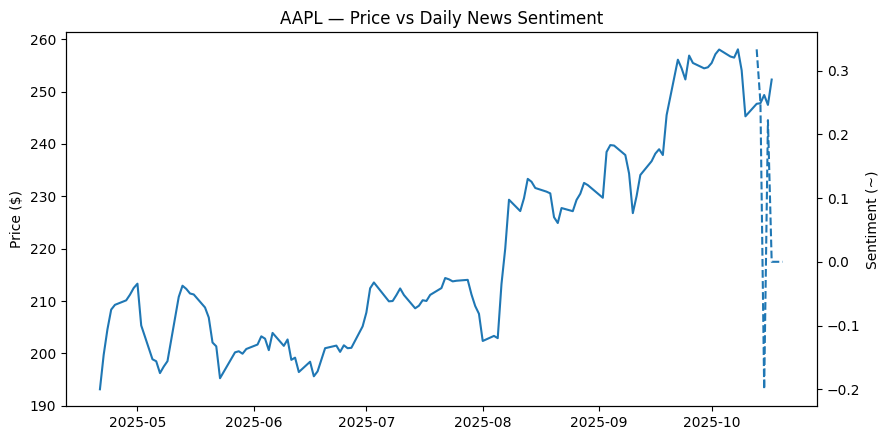

In [57]:
#Step-9
print("="*80)
print("PLAN:", plan)
print("="*80)
print("DRAFT REPORT (first 600 chars):\n", agg["draft_text"][:600], "...")
print("="*80)
print("EVALUATOR:", scores)
print("="*80)
print("FINAL REPORT (first 800 chars):\n", final_text[:800], "...")
print("="*80)
print("LAST MEMORY NOTES:", memory.tail(TICKER))

# Chart: Price vs Daily Net Sentiment (if any)
daily_sent_plot = news_df.assign(day=news_df["published_time"].dt.date)\
                         .groupby("day")["sentiment"].mean()

fig, ax1 = plt.subplots(figsize=(9, 4.5))
ax1.plot(pd.to_datetime(prices_df["Date"]), prices_df["Close"], label="AAPL Close")
ax1.set_ylabel("Price ($)")
ax1.set_title("AAPL — Price vs Daily News Sentiment")
ax2 = ax1.twinx()
if not daily_sent_plot.empty:
    ax2.plot(pd.to_datetime(daily_sent_plot.index), daily_sent_plot.values, linestyle="--", label="Daily Net Sentiment")
ax2.set_ylabel("Sentiment (~)")
fig.tight_layout()
plt.show()
